## Exemplary script for constrained simultaneous retrieval

This Python notebook provides an exemplary script for the constrained simultaneous retrieval of sea ice thickness d and sea ice Salinity d. Brightness temperature (TB) simulation is computed with SMRT. Therefore, to run the script it is required to have SMRT installed. I had SMRT installed on the server of University of Hamburg. Hence, if working here, simply run

-> module load anaconda3

in your terminal prior to executing this script. When working from your home PC, you must install SMRT first. Therefore, you can use

-> git clone https://github.com/smrt-model/smrt



Please make sure you set the Pythonpath for SMRT in your /.bash_rc. Therefore, edit your /.bash_rc with

-> export PYTHONPATH="/home/User/location/smrt"


For a more detailed description on how to install SMRT, see https://github.com/smrt-model.




For more information in the below script, have a look in my Thesis $\textit{Advancing sea ice remote sensing through wideband brightness temperature simulation}$ 

or feel free to contact me: simon.we@me.com




Note: TB simulation with SMRT is likely to cause multi-threading. You can avoid multi-threading by implementing 


in your code.

For beginning make sure to chose low N and low NI to keep computational time at a minimum

The initial step is to load, among others, necessary SMRT modules.

In [102]:
%pylab inline
import scipy.stats as stats
import pandas as pd
from io import StringIO
from scipy.optimize import curve_fit, minimize
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

#load SMRT modules
from smrt import make_model, make_snowpack, sensor_list, make_ice_column
from smrt.utils import dB
from smrt import PSU
from smrt.permittivity.wetsnow import wetsnow_permittivity

Populating the interactive namespace from numpy and matplotlib


The following cell defines functions that initiat TB simulation. Functions will be called by the retrieval algorithm.

In [145]:
########################## TB simulation #############################################################################

#TB in dependency of d and S
def Tb_S_d(p):
    d,S_ice=p[0],p[1]
    T_ice = linspace(273.15+(temperature_init), 273.15 - 1.8, 2*set_layers+1)
    c=1.0
    return Tb_f(c,d,T_ice,S_ice)

#TB simulation with SMRT for frequency f
def Tb_f(c,d,T_ice,S_ice):
    Tb=[]
    for f in frequency:
        sensor = sensor_list.passive(f*1e9, incidence_angle) #sensor configuration
        temperature = linspace(273.15+(surface_temperature), 273.15+(water_temperature), 2*set_layers+1)
                                #temperature gradient in the ice from surface temp
                                #at top to temperature of water at bottom
        temperature = temperature[1::2] # average temperatures of layers (=temperature at midpoints)
        thickness = array([d/set_layers] * set_layers) #thickness of each layer
        salinity = S_ice*PSU #PSU as SI unit for SMRT
        
        #modelling of a sea ice column with the make layer submodel
        ice_column = make_ice_column(ice_type=ice_type,thickness=thickness,
                                temperature=temperature,
                                microstructure_model="exponential",
                                brine_inclusion_shape=inclusion_shape, 
                                salinity=salinity,
                                corr_length=corr_length,
                                add_water_substrate="ocean"
                                )

        # run the model
        res = m.run(sensor, ice_column)
        res_TB = (res.TbH() + res.TbV())/2 #mean TB from vertically and horizontally polarized TB
        Tb.append(res_TB)
    return array(Tb)

The next cell defines the objective function, which is minimised by the algorithm. 

In [146]:
# objective func
def objective_func(p, noise):
    Tb_model=Tb_S_d(p)
    return linalg.norm((Tb_model-noise)**2) #calculates Norm (L2-norm, Frobius), as we cannot 
                                                #use the vector in opti.minimize
    

Next, functions that constrain the retrieval algorithm are defined.

In [147]:
############################# subject funtion/constraint #############################################################

def subject_func(p):
    S_init         = p[1] #get true salinity 
    salinity_diff = abs(S_d(p) - S_init) #calculate difference S_mod - S_true
    return G - salinity_diff #must be non-negative


############################ Salinity parameterisations ##############################################################

def Kovacs_fit(p): #S(d) from Kovacs
    d = p[0]
    Sw = 31
    Sr2 = 0.175
    a = 0.5
    return (Sw*(1-Sr2)*exp(-a*sqrt(d*100))+Sr2*Sw)

def Ryvlin_fit(p): #S(d) from Kovacs
    d = p[0]
    Sw = 31
    Sr2 = 0.13
    a = 0.5
    return (Sw*(1-Sr2)*exp(-a*sqrt(d*100))+Sr2*Sw)

def Nice_fit(p): #fit from NICE
    d = p[0]
    return 3.592 + divide(1.056,d)

def Combi_fit(p): #fit from NICE
    d = p[0]
    return 4.606 + divide(91.603,d)


The constrained retrieval is adjusted by the following parameters

In [148]:
Gtol = 1e-3 #stopping criteria
G = 3 # threshold that constrains the subject function
N_TB_f = 2 # number of frequencies considered in the retrieval
FI = 5 #sample density for retrieval
def S_d(p):
    return Kovacs_fit(p) #change salnity parameterisation to desired S(d)
                        #a more detailed description on implemented S(d) is given in my thesis in section 5.

Define SMRT settings

In [149]:
###########################  SMRT setting  #################################################

#medium settings
ice_type = 'firstyear' # first-year or multi-year sea ice
porosity = 0. # ice porosity in fractions, [0..1]
surface_temperature = -20 
water_temperature = -1.8
corr_length = 1.0e-3 #correlation length
inclusion_shape={"spheres":1,"random_needles":0} #set ratio of spheres and needles

#create the sensor
incidence_angle = 30 #angle of incidence
n_max_stream = 32 #number of computed streams
frequency = linspace(0.5,4,N_TB_f) #frequencies in GHz
len_frequency = len(frequency)
m = make_model("iba", "dort", rtsolver_options ={"n_max_stream": n_max_stream}) #define the model

Select value ranges and boundaries for the retrieval

In [150]:
###################### settings for the retrieval ###################################################################

bounds = ((0.02,1),(1,25)) #d bounds and S bounds
d_range= linspace(0.02,1,1*FI+1) #value range of investigated sea ice thickness
S_range= linspace(1,25,1*FI+1) #value range of investigated sea ice salinity
layers = 5 #np.round(np.linspace(2,10,len(d_range))).astype(int) #number of ice layers predefined
N = 10 # number of times retrieval of each (d,S) is repeated - for statistics (mean and std)

The following cell executes the retrieval

In [151]:
RM_restricted = np.zeros((len(d_range),len(S_range),4))
    #array, which will be filled with re
for di,d in enumerate(d_range):
    d_try=d #initial thickness guess
    set_layers = layers #chose number of layers depending on sea ice thickness
    for si,s in enumerate(S_range):
        retrieval=[] #refresh retrieval array
        S_try = s 
        for i in range(N): # retrieval is repeated N times for stats
            p_try        = (d_try,S_try) # initial value (d,S)
            Tb_obs       = Tb_S_d(p_try) # simulate observed Tb
            Tb_obs_noise = Tb_obs + scipy.randn(len_frequency)*0.5 # Simulate measurement noise
            initial_guess = array([0.5,6.0]) # initial guess (d,S): starting point for the retrieval
 
            # solve inversion problem with minimize-func
            result  =  minimize(objective_func, initial_guess,
                                args        = (Tb_obs_noise,), 
                                bounds      = bounds, 
                                method      = 'SLSQP',
                                tol         = 1e-3,
                                constraints = {'type': 'ineq', 'fun': subject_func}) #constraint type: inequality
            retrieval.append(result.x) #collect retrieval
        retrieval = np.array(retrieval)
        d_retrieval,d_sig_retrieval = mean(retrieval[:,0]),std(d_try-retrieval[:,0])
        S_retrieval,S_sig_retrieval = mean(retrieval[:,1]),std(S_ice_try-retrieval[:,1])
        RM_restricted[di,si,0] = d_try-d_retrieval
        RM_restricted[di,si,1] = d_sig_retrieval
        RM_restricted[di,si,2] = S_ice_try-S_retrieval
        RM_restricted[di,si,3] = S_sig_retrieval

KeyboardInterrupt: 

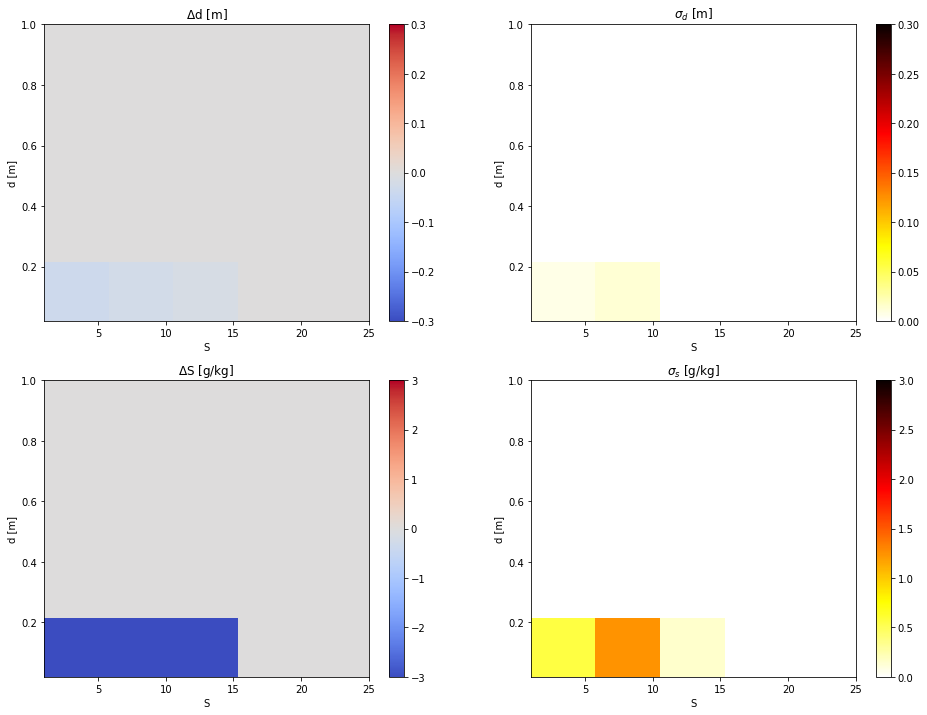

In [152]:
############################# plot result ####################################################################

results_fig = figure(figsize=(16,12))
subplot(2,2,1)
pcolormesh(S_range,d_range,RM_restricted[:,:,0], cmap=cm.coolwarm,vmin=-0.3,vmax=0.3)
xlabel('S')
ylabel('d [m]')
colorbar()
title('$\Delta$d [m]')

subplot(2,2,2)
pcolormesh(S_range,d_range,RM_restricted[:,:,1], cmap=cm.hot_r,vmin=0,vmax=0.3)
xlabel('S')
ylabel('d [m]')
title('$\sigma_d$ [m]')
colorbar()

subplot(2,2,3)
pcolormesh(S_range,d_range,RM_restricted[:,:,2], cmap=cm.coolwarm,vmin=-3,vmax=3)
xlabel('S')
ylabel('d [m]')
colorbar()
title('$\Delta$S [g/kg]')
subplot(2,2,4)

pcolormesh(S_range,d_range,RM_restricted[:,:,3], cmap=cm.hot_r,vmin=0,vmax=3)
xlabel('S')
ylabel('d [m]')
title('$\sigma_s$ [g/kg]')
colorbar()